In [1]:
from utils import *
import time
import numpy as np
import pandas as pd
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
import bert
import warnings
warnings.filterwarnings('ignore')
context = mx.cpu(); model_ctx = mx.cpu()
mx.random.seed(1719)

/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def parse(X):
    return datetime.datetime.strptime(X, '%Y-%m-%d')

In [3]:
AAPL = pd.read_csv('AAPL.csv', header = 0, parse_dates = [0], date_parser = parse)
print('There are {} number of days in the dataset'.format(AAPL.shape[0]))
AAPL['Close'] = AAPL['Adj Close']
AAPL.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)

There are 2263 number of days in the dataset


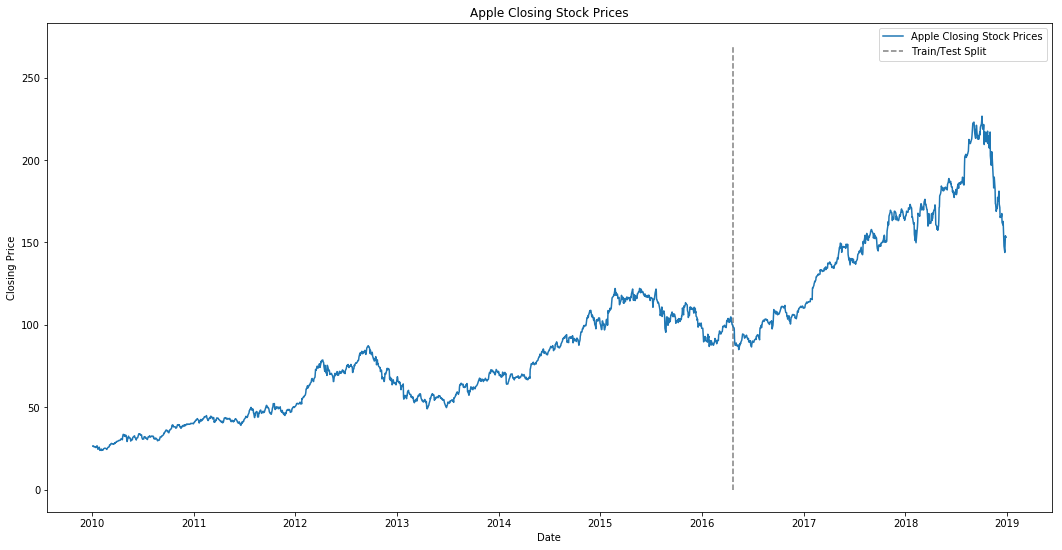

In [4]:
plt.figure(figsize = (18, 9))
plt.plot(AAPL['Date'], AAPL['Close'], label = 'Apple Closing Stock Prices')
plt.vlines(datetime.date(2016, 4, 20), 0, 270, linestyles = '--', colors = 'gray', label = 'Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Apple Closing Stock Prices')
plt.legend()

In [5]:
num_training_days = int(AAPL.shape[0] * 0.7)
print('Number of Training Days: {}. Number of Testing Days: {}.'.format(num_training_days, 
                                                                        AAPL.shape[0] - num_training_days))

Number of Training Days: 1584. Number of Testing Days: 679.


In [6]:
def get_technical_indicators(dataset):
    dataset['MA7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['MA21'] = dataset['Close'].rolling(window = 21).mean()
    dataset['26EWMA'] = dataset['Close'].ewm(span = 26).mean()
    dataset['12EWMA'] = dataset['Close'].ewm(span = 12).mean()
    dataset['MACD'] = dataset['12EWMA'] - dataset['26EWMA']
    dataset['20STD'] = dataset['Close'].rolling(20).std()
    dataset['Upper Band'] = dataset['MA21'] + (2 * dataset['20STD'])
    dataset['Lower Band'] = dataset['MA21'] - (2 * dataset['20STD'])
    dataset['EWMA'] = dataset['Close'].ewm(com = 0.5).mean()
    dataset['Momentum'] = dataset['Close'] - 1
    dataset['Logarithmic Momentum'] = np.log(dataset['Momentum'])
    return dataset

In [7]:
AAPL_TI = get_technical_indicators(AAPL)
AAPL_TI.head()

,Date,Close,MA7,MA21,26EWMA,12EWMA,MACD,20STD,Upper Band,Lower Band,EWMA,Momentum,Logarithmic Momentum
0,2010-01-04,26.466835,NaN,NaN,26.466835,26.466835,0.000000,NaN,NaN,NaN,26.466835,25.466835,3.237377
1,2010-01-05,26.512596,NaN,NaN,26.490596,26.491622,0.001027,NaN,NaN,NaN,26.501156,25.512596,3.239172
2,2010-01-06,26.090879,NaN,NaN,26.346981,26.335212,-0.011769,NaN,NaN,NaN,26.217118,25.090879,3.222504
3,2010-01-07,26.042646,NaN,NaN,26.261902,26.242860,-0.019042,NaN,NaN,NaN,26.099349,25.042646,3.220580
4,2010-01-08,26.215786,NaN,NaN,26.251208,26.235504,-0.015703,NaN,NaN,NaN,26.177295,25.215786,3.227470


In [8]:
def plot_technical_indicators(dataset, days):
    plt.figure(figsize = (18, 9))
    shape = dataset.shape[0]
    xMACD = shape - days
    dataset = dataset.iloc[-days:, :]
    x = range(3, shape)
    x = list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['MA7'], label = 'MA7', color = 'g', linestyle = '--')
    plt.plot(dataset['Close'], label = 'Closing Price', color = 'b')
    plt.plot(dataset['MA21'], label = 'MA21', color = 'r', linestyle = '--')
    plt.plot(dataset['Upper Band'], label = 'Upper BB', color = 'c')
    plt.plot(dataset['Lower Band'], label = 'Lower BB', color = 'c')
    plt.fill_between(x, dataset['Lower Band'], dataset['Upper Band'], alpha = 0.4)
    plt.title('Technical Indicators for Apple: Previous {} Days'.format(shape))
    plt.ylabel('Price')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'], label = 'MACD', linestyle = '-.')
    plt.hlines(15, xMACD, shape, colors = 'g', linestyles = '--')
    plt.hlines(-15, xMACD, shape, colors = 'g', linestyles = '--')
    plt.plot(dataset['Logarithmic Momentum'], label = 'Momentum', color = 'b', linestyle = '-')
    plt.legend()

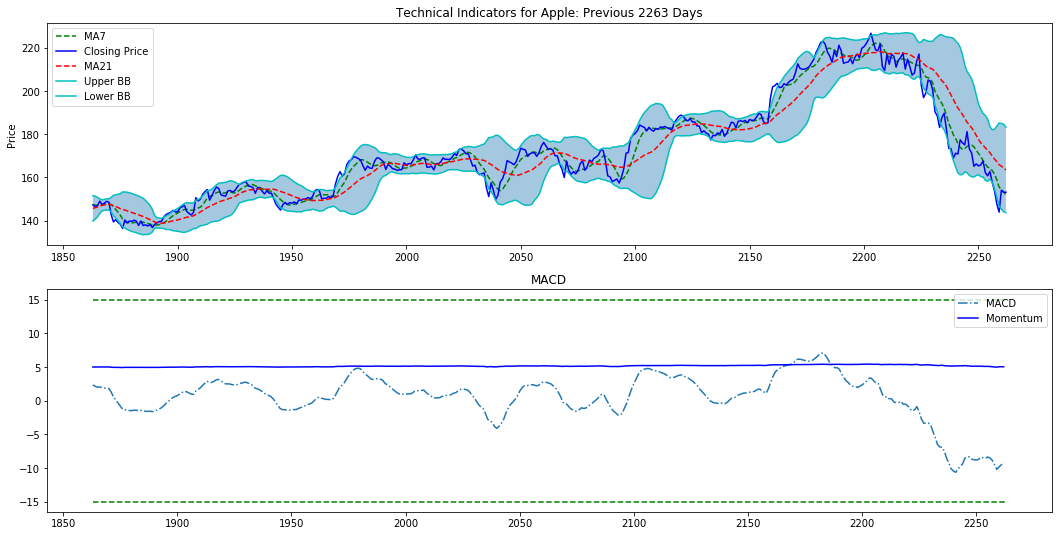

In [9]:
plot_technical_indicators(AAPL, 400)

In [10]:
FTData = AAPL[['Date', 'Close']]
closeFFT = np.fft.fft(np.asarray(FTData['Close'].tolist()))
FFT = pd.DataFrame({'FFT': closeFFT})
FFT['Absolute'] = FFT['FFT'].apply(lambda x: np.abs(x))
FFT['Angle'] = FFT['FFT'].apply(lambda x: np.angle(x))

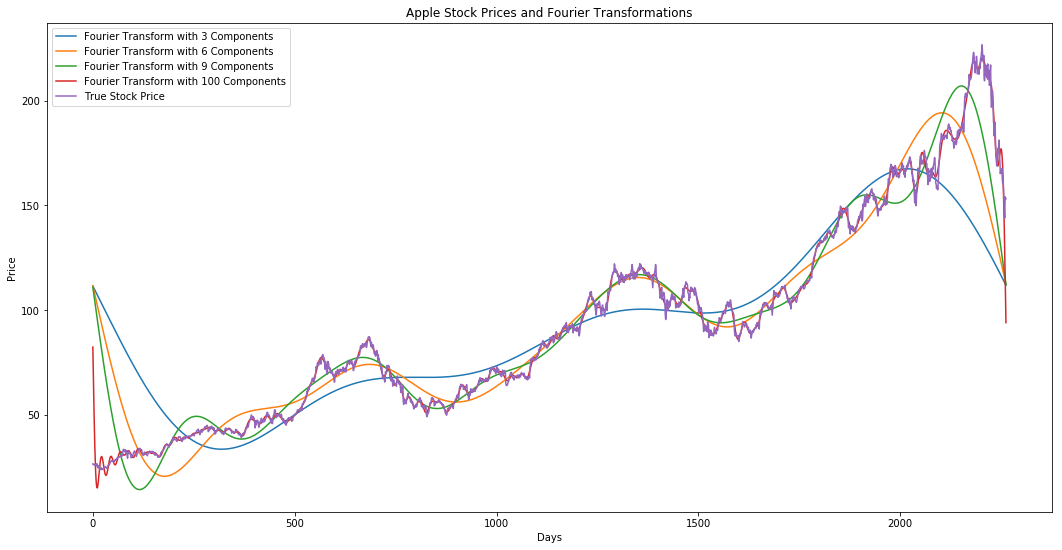

In [11]:
plt.figure(figsize = (18, 9))
FFTList = np.asarray(FFT['FFT'].tolist())
for num in [3, 6, 9, 100]:
    FFTListM10 = np.copy(FFTList); FFTListM10[num: -num] = 0
    plt.plot(np.fft.ifft(FFTListM10), label = 'Fourier Transform with {} Components'.format(num))
plt.plot(FTData['Close'], label = 'True Stock Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Apple Stock Prices and Fourier Transformations')
plt.legend()

In [26]:
def get_feature_importance_data(data):
    data = data.copy()
    y = data['Close']
    X = data.iloc[:, 2:]
    train_samples = int(X.shape[0] * 0.7)
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]
    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    return (X_train, y_train), (X_test, y_test)

In [27]:
(X_train, y_train), (X_test, y_test) = get_feature_importance_data(AAPL_TI)

In [28]:
regressor = xgb.XGBRegressor(gamma = 0.0, n_estimators = 150, base_score = 0.7, colsample_bytree = 1, learning_rate = 0.05)

In [29]:
xgbModel = regressor.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = False)

In [30]:
eval_result = regressor.evals_result()

In [31]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

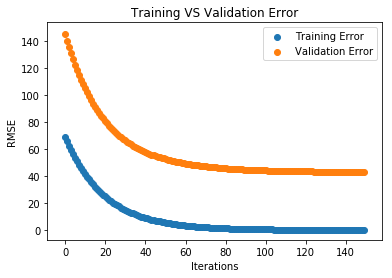

In [32]:
plt.scatter(x = training_rounds,y = eval_result['validation_0']['rmse'], label = 'Training Error')
plt.scatter(x = training_rounds,y = eval_result['validation_1']['rmse'], label = 'Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training VS Validation Error')
plt.legend()
plt.show()

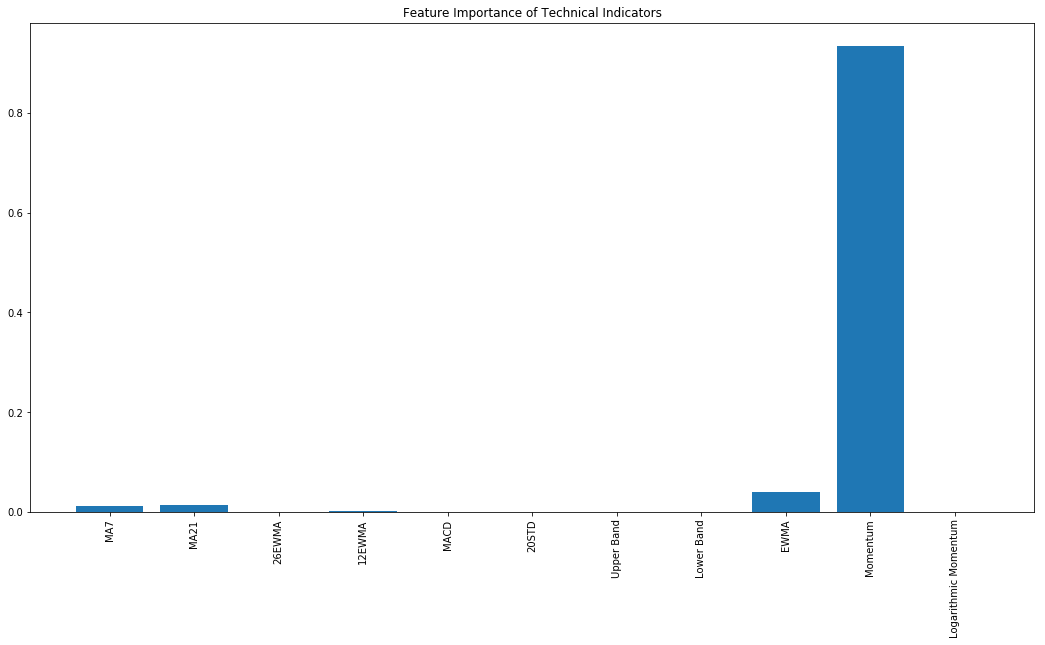

In [33]:
fig = plt.figure(figsize = (18, 9))
plt.xticks(rotation = 'vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), 
        tick_label = X_test.columns)
plt.title('Feature Importance of Technical Indicators')
plt.show()